In [1]:
from pybsd import *
import numpy as np
from jax import numpy as jnp 
from jax import grad, hessian, jit
from collections import OrderedDict
from functools import partial

In [12]:
Hz = [*range(1,64)]
freqs = [[8, 12], [14,24], [32, 40], [48, 54]]

bsd = BSD(Hz, freqs, atol=1e-1, hE = np.asarray([12]), hC=np.asarray([1/64]))

In [13]:
P = vectorize(bsd.spec2param(ampl=np.array([1, 0.5, 0., 0.2])))

In [14]:
Y = jnp.exp(jnp.log(bsd.forward(P))+0.5*np.random.normal(size=(200, len(Hz))))

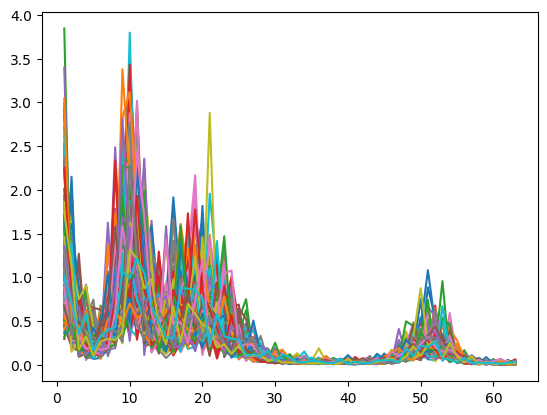

In [15]:
import matplotlib.pyplot as plt
for i in range(Y.shape[0]):
    plt.plot(bsd.Hz, Y[i])

In [16]:
res = bsd.fit(Y)

EM: (+) 0: F-F0: 0.00e+00 dF (predicted): 2.19e-02 (actual): 1.91e+05 (82.35 ms)
EM: (+) 1: F-F0: 1.91e+05 dF (predicted): 5.83e+05 (actual): -2.80e+07 (82.37 ms)
EM: (-) 2: F-F0: 1.91e+05 dF (predicted): 9.68e+04 (actual): -1.01e+02 (8.51 ms)
EM: (-) 3: F-F0: 1.91e+05 dF (predicted): 1.35e+04 (actual): 6.14e+02 (34.66 ms)
EM: (+) 4: F-F0: 1.92e+05 dF (predicted): 1.11e+03 (actual): -9.49e+03 (69.68 ms)
EM: (-) 5: F-F0: 1.92e+05 dF (predicted): 1.58e+02 (actual): -5.90e+01 (7.73 ms)
EM: (-) 6: F-F0: 1.92e+05 dF (predicted): 2.15e+01 (actual): 3.13e+01 (12.27 ms)
EM: (+) 7: F-F0: 1.92e+05 dF (predicted): 3.50e+01 (actual): 4.59e+01 (14.26 ms)
EM: (+) 8: F-F0: 1.92e+05 dF (predicted): 3.67e+01 (actual): 6.75e+01 (26.13 ms)
EM: (+) 9: F-F0: 1.92e+05 dF (predicted): 7.38e+01 (actual): 1.78e+02 (32.30 ms)
EM: (+) 10: F-F0: 1.92e+05 dF (predicted): 1.50e+02 (actual): -1.64e+02 (20.98 ms)
EM: (-) 11: F-F0: 1.92e+05 dF (predicted): 2.10e+01 (actual): 5.44e+01 (16.55 ms)
EM: (+) 12: F-F0: 1.92e

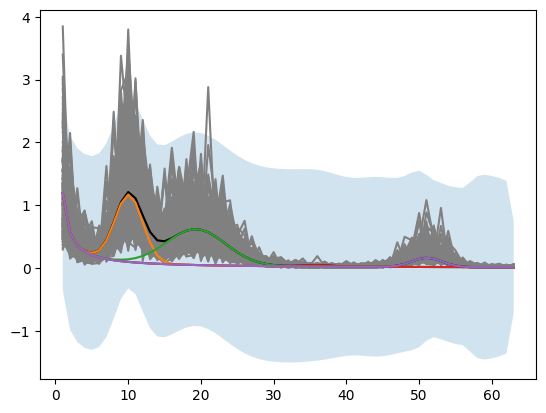

In [17]:
import matplotlib.pyplot as plt
for i in range(Y.shape[0]):
    plt.plot(bsd.Hz, Y[i], 'gray')
Yp = bsd.forward(res['Ep']).squeeze()
Sy = np.sqrt(np.diag(res['Cy']))
plt.fill_between(bsd.Hz, Yp - Sy, Yp + Sy, alpha=0.2)
plt.plot(bsd.Hz, Yp, 'k')

Ha =  bsd.aperiodic_component(res['Ep']).squeeze()
plt.plot(bsd.Hz, Ha) 
Hp =  bsd.periodic_components(res['Ep']).squeeze()
for i in range(Hp.shape[0]):
    plt.plot(bsd.Hz, Hp[i] + Ha) 

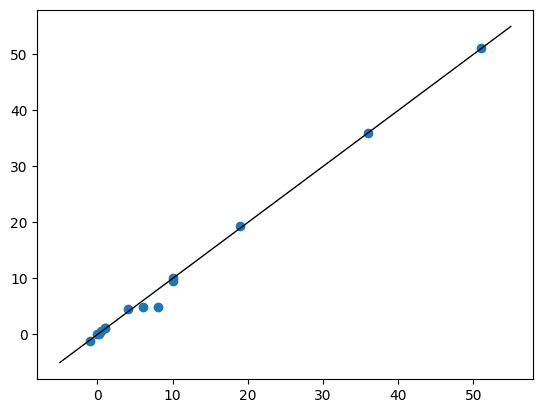

In [18]:
plt.plot([-5, 55], [-5, 55], 'k', linewidth=1)
plt.scatter(vectorize(bsd.param2spec(P)), vectorize(bsd.param2spec(res['Ep'])))

In [19]:
model_space = np.unpackbits(np.arange(2**len(freqs), dtype=np.uint8), bitorder='little').reshape((2**len(freqs), 8))[:, :len(freqs)].astype(bool)

In [20]:
freqs = np.asarray(freqs)
models = []
for sel in model_space:
    models.append(BSD(Hz, freqs[sel, :], atol=5e-1, hE = np.asarray([12]), hC=np.asarray([1/8])).fit(Y))

EM: (+) 0: F-F0: 0.00e+00 dF (predicted): 2.86e-03 (actual): 1.54e+05 (31.79 ms)
EM: (+) 1: F-F0: 1.54e+05 dF (predicted): 5.18e+06 (actual): 1.03e+01 (6.40 ms)
EM: (+) 2: F-F0: 1.54e+05 dF (predicted): 1.86e-06 (actual): 4.96e-01 (7.09 ms)
EM: (+) 3: F-F0: 1.54e+05 dF (predicted): 5.13e-06 (actual): 2.90e-03 (9.09 ms)
EM: (+) 4: F-F0: 1.54e+05 dF (predicted): 1.39e-05 (actual): 0.00e+00 (7.68 ms)
EM: (-) 5: F-F0: 1.54e+05 dF (predicted): 6.16e+00 (actual): 1.99e-01 (6.31 ms)
EM: (+) 6: F-F0: 1.54e+05 dF (predicted): 1.68e+01 (actual): 4.58e-01 (10.34 ms)
EM: (+) 7: F-F0: 1.54e+05 dF (predicted): 4.56e+01 (actual): 1.26e+00 (6.47 ms)
EM: (+) 8: F-F0: 1.54e+05 dF (predicted): 1.24e+02 (actual): 3.49e+00 (10.92 ms)
EM: (+) 9: F-F0: 1.54e+05 dF (predicted): 3.33e+02 (actual): 9.95e+00 (7.30 ms)
EM: (+) 10: F-F0: 1.54e+05 dF (predicted): 8.47e+02 (actual): 1.30e+01 (13.13 ms)
EM: (+) 11: F-F0: 1.54e+05 dF (predicted): 9.74e+02 (actual): 2.22e+01 (15.17 ms)
EM: (+) 12: F-F0: 1.54e+05 dF (pr

[[ 8 12]
 [14 24]
 [48 54]]


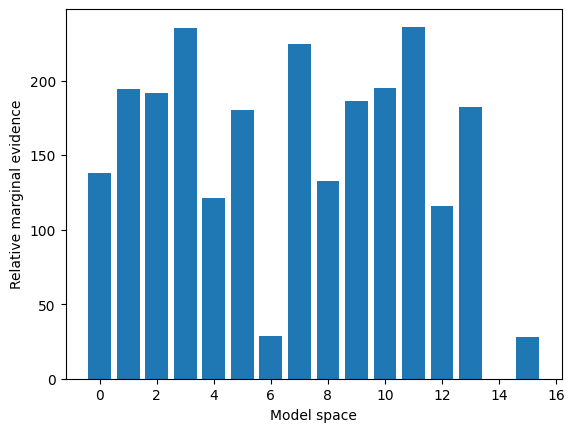

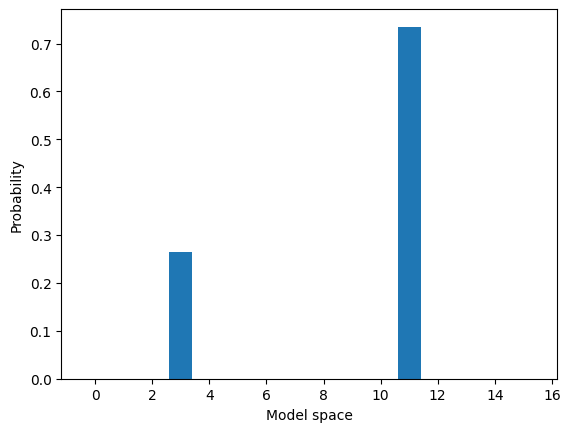

In [22]:
Fs = np.asarray([*map(lambda _:_['F'], models)])
plt.bar(np.arange(2**len(freqs)),Fs-min(Fs))
plt.xlabel('Model space')
plt.ylabel('Relative marginal evidence')
prob = np.exp(Fs-Fs.max())/ np.exp(Fs-Fs.max()).sum()
plt.figure()
plt.bar(np.arange(2**len(freqs)),prob)
plt.xlabel('Model space')
plt.ylabel('Probability')

I = np.argmax(Fs)
print(freqs[model_space[I]])